In [1]:
!pip3 install transformers

In [2]:
!pip install opacus

In [3]:
# Importing libraries
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time
import opacus
from opacus import PrivacyEngine 
import copy
import os
import logging
logging.basicConfig(level=logging.ERROR)

In [4]:
# Setting up GPU
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/My Drive/dep1_cleaned.csv')
df.head()

,Unnamed: 0,tweet,target
0,0,Today in Selfcare: beauty ; laughs Kung Fu Pan...,0
1,1,I get to spend New Year's home again alone and...,1
2,2,"Depressed and lonely /: Stuck in a deep, never...",1
3,3,If this is your response to someone saying the...,0
4,4,Apparently you get a free pass just by mention...,0


##Partitioning

###IID

In [7]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

###Non-IID

In [8]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.get_labels()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict

# MAIN

## MODELS

In [9]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 4)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [10]:
model = DistillBERTClass()
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

In [11]:
trainable_layers = [model.pre_classifier, model.classifier]
total_params = 0
trainable_params = 0

for p in model.parameters():
        p.requires_grad = False
        total_params += p.numel()

for layer in trainable_layers:
    for p in layer.parameters():
        p.requires_grad = True
        trainable_params += p.numel()

print(f"Total parameters count: {total_params}") # ~125M
print(f"Trainable parameters count: {trainable_params}") # ~0.5M

Total parameters count: 66956548
Trainable parameters count: 593668


In [12]:
#Initialization
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 2
#EPOCHS = 10
LEARNING_RATE = 1e-05
LOGGING_INTERVAL = 100 # once every how many steps we run evaluation cycle and report metrics
 # Parameter for privacy accounting. Probability of not achieving privacy guarantees
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [13]:
#The class is defined to accept the Dataframe as input and generate tokenized output that is used by the DistilBERT model for training.
#The tokenizer uses the encode_plus method to perform tokenization and generate the necessary outputs, namely: ids, attention_mask
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def get_labels(self):
        l=[]
        for i in range(self.len):
          title = str(self.data.tweet[i])
          title = " ".join(title.split())
          inputs = self.tokenizer.encode_plus(
              title,
              None,
              add_special_tokens=True,
              max_length=self.max_len,
              padding='max_length',
              return_token_type_ids=True,
              truncation=True
          )

          l.append(self.data.target[i])

        return l



        
    def __getitem__(self, index):
        title = str(self.data.tweet[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.target[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [14]:
class CustomDataset(Dataset):
  def __init__(self, dataset, tokenizer, max_len, idxs):
      self.data = dataset
      self.idxs = list(idxs)
      self.text = dataset.tweet
      self.tokenizer = tokenizer
      self.max_len = max_len
      self.targets = self.data.target
      
  # def __init__(self, dataset, idxs):
  #     self.dataset = dataset
  #     self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, index):
      text = str(self.text[index])
      text = " ".join(text.split())

      inputs = self.tokenizer.encode_plus(
          text,
          None,
          add_special_tokens=True,
          max_length=self.max_len,
          pad_to_max_length=True,
          return_token_type_ids=True
      )
      ids = inputs['input_ids']
      mask = inputs['attention_mask']
      #token_type_ids = inputs["token_type_ids"]


      return {
          'ids': torch.tensor(ids, dtype=torch.long),
          'mask': torch.tensor(mask, dtype=torch.long),
          #'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
          'targets': torch.tensor(self.targets[index], dtype=torch.float)
      }

class ClientUpdate(object):
  def __init__(self, dataset, model, tokenizer, loss_function, optimizer, idxs, epochs, MAX_LEN=256):
    self.train_loader = DataLoader(CustomDataset(dataset, tokenizer, MAX_LEN, idxs), batch_size=8, shuffle=True)
    self.model = model
    self.dataset = dataset
    self.loss_function = loss_function
    self.optimizer = optimizer
    self.epochs = epochs

  # Function to calcuate the accuracy of the model

  def calcuate_accu(self, big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

  def train(self):

    epochloss, epochacc = [], []

    for epoch in range(1, self.epochs+1):
      tr_loss = 0
      n_correct = 0
      nb_tr_steps = 0
      nb_tr_examples = 0
      losses = []
      model.train()
      for _,data in tqdm(enumerate(training_loader, 0)):
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          #token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.long)

          outputs = model(ids, mask)
          loss = loss_function(outputs, targets)
          tr_loss += loss.item()
          big_val, big_idx = torch.max(outputs.data, dim=1)
          n_correct += self.calcuate_accu(big_idx, targets)

          nb_tr_steps += 1
          nb_tr_examples+=targets.size(0)
          
          if _%2000==0:
              loss_step = tr_loss/nb_tr_steps
              accu_step = (n_correct*100)/nb_tr_examples 
              print(f"Training Loss per 5000 steps: {loss_step}")
              print(f"Training Accuracy per 5000 steps: {accu_step}")

          self.optimizer.zero_grad()
          loss.backward()
          losses.append(loss.item())
          # # When using GPU
          if (_ + 1) % 2000 == 0 or _ == len(training_loader) - 1:
              self.optimizer.step()
          else:
              self.optimizer.virtual_step()

          if _ > 0 and _ % 2000 == 0:
                train_loss = np.mean(losses)
                eps, alpha = self.optimizer.privacy_engine.get_privacy_spent(DELTA)

                eval_accuracy,eval_loss = valid(model, testing_loader)

                print(
                    f"Epoch: {epoch} | "
                    f"Step: {_} | "
                    f"Train loss: {train_loss:.3f} | "
                    f"Eval loss: {eval_loss:.3f} | "
                    f"Eval accuracy: {eval_accuracy:.3f} | "
                    f"ɛ: {eps:.2f} (α: {alpha})"
                )

          
      print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
      epoch_loss = tr_loss/nb_tr_steps
      epoch_accu = (n_correct*100)/nb_tr_examples
      print(f"Training Loss Epoch: {epoch_loss}")
      print(f"Training Accuracy Epoch: {epoch_accu}")
      epochacc.append(epoch_accu)
      epochloss.append(epoch_loss)


    return model.state_dict(), epochacc[-1], epochloss[-1]

In [15]:
def training(model, rounds, ds, data_dict, loss_function, lr, C, K, E,plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss,train_acc = [], []
  
  optimizer = torch.optim.AdamW(params =  model.parameters(), lr=lr)
  
  # measure time
  start = time.time()

  LOGGING_INTERVAL = 100 # once every how many steps we run evaluation cycle and report metrics
  EPSILON = 5
  DELTA = 1 / len(training_set) # Parameter for privacy accounting. Probability of not achieving privacy guarantees

  SAMPLE_RATE = 8/len(ds)
  MAX_GRAD_NORM = 0.1
  VIRTUAL_BATCH_SIZE = 32
  assert VIRTUAL_BATCH_SIZE % 8 == 0 # VIRTUAL_BATCH_SIZE should be divisible by BATCH_SIZE
  N_ACCUMULATION_STEPS = int(VIRTUAL_BATCH_SIZE / 8)

  privacy_engine = PrivacyEngine(
      module=model,
      sample_rate=SAMPLE_RATE * N_ACCUMULATION_STEPS,
      target_delta = DELTA,
      target_epsilon = EPSILON, 
      epochs = E,
      max_grad_norm=MAX_GRAD_NORM,
  )

  privacy_engine.attach(optimizer)
    

  for curr_round in range(1, rounds+1):
    w, local_loss,local_acc = [], [], []

    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False)
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, model=model, tokenizer=tokenizer, loss_function=loss_function, \
                                  optimizer=optimizer, epochs=E, idxs=data_dict[k])
      weights, acc, loss = local_update.train()

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
      local_acc.append(copy.deepcopy(acc))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    acc_avg = sum(local_acc) / len(local_acc)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    print('Round: {}... \tAverage Accuracy: {}'.format(curr_round, round(acc_avg, 3)))
    train_loss.append(loss_avg)
    train_acc.append(acc_avg)

  end = time.time()
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  # y_axis = np.array(train_loss)
  # ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  # ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
  #      title="Training Loss")
  
  y_axis = np.array(train_acc)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Accuracy',
       title="Training Accuracy vs. Global rounds")
  ax.grid()
  #fig.savefig(plt_title+'.jpg', format='jpg')
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))
  
  return model

In [16]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (3096, 3)
TRAIN Dataset: (2477, 3)
TEST Dataset: (619, 3)


In [17]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full b

Training Loss per 5000 steps: 1.3563532829284668
Training Accuracy per 5000 steps: 25.0


310it [00:20, 15.18it/s]
2it [00:00, 16.05it/s]

The Total Accuracy for Epoch 1: 25.232135647961243
Training Loss Epoch: 1.3798516715726545
Training Accuracy Epoch: 25.232135647961243
Training Loss per 5000 steps: 1.421688199043274
Training Accuracy per 5000 steps: 0.0


310it [00:20, 14.95it/s]
2it [00:00, 15.35it/s]

The Total Accuracy for Epoch 1: 25.87807832054905
Training Loss Epoch: 1.3780159496491955
Training Accuracy Epoch: 25.87807832054905
Training Loss per 5000 steps: 1.3689042329788208
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.45it/s]
2it [00:00, 14.85it/s]

The Total Accuracy for Epoch 1: 25.595478401291885
Training Loss Epoch: 1.3775147026584995
Training Accuracy Epoch: 25.595478401291885
Round: 1... 	Average Loss: 1.378
Round: 1... 	Average Accuracy: 25.569
Training Loss per 5000 steps: 1.3660757541656494
Training Accuracy per 5000 steps: 37.5


310it [00:22, 14.00it/s]
2it [00:00, 14.81it/s]

The Total Accuracy for Epoch 1: 27.45256358498183
Training Loss Epoch: 1.3774436462310053
Training Accuracy Epoch: 27.45256358498183
Training Loss per 5000 steps: 1.375370979309082
Training Accuracy per 5000 steps: 25.0


310it [00:23, 13.42it/s]
2it [00:00, 14.60it/s]

The Total Accuracy for Epoch 1: 24.10173597093258
Training Loss Epoch: 1.3794288442980858
Training Accuracy Epoch: 24.10173597093258
Training Loss per 5000 steps: 1.366163730621338
Training Accuracy per 5000 steps: 37.5


310it [00:22, 13.85it/s]
2it [00:00, 14.23it/s]

The Total Accuracy for Epoch 1: 27.048849414614452
Training Loss Epoch: 1.376100787424272
Training Accuracy Epoch: 27.048849414614452
Round: 2... 	Average Loss: 1.378
Round: 2... 	Average Accuracy: 26.201
Training Loss per 5000 steps: 1.403895378112793
Training Accuracy per 5000 steps: 12.5


310it [00:22, 14.06it/s]
2it [00:00, 14.48it/s]

The Total Accuracy for Epoch 1: 25.756964069438837
Training Loss Epoch: 1.3783940003764246
Training Accuracy Epoch: 25.756964069438837
Training Loss per 5000 steps: 1.3983052968978882
Training Accuracy per 5000 steps: 12.5


310it [00:22, 13.85it/s]
2it [00:00, 14.72it/s]

The Total Accuracy for Epoch 1: 26.241421073879692
Training Loss Epoch: 1.378474690837245
Training Accuracy Epoch: 26.241421073879692
Training Loss per 5000 steps: 1.3841030597686768
Training Accuracy per 5000 steps: 0.0


310it [00:22, 13.75it/s]


The Total Accuracy for Epoch 1: 25.47436415018167
Training Loss Epoch: 1.3776760393573393
Training Accuracy Epoch: 25.47436415018167
Round: 3... 	Average Loss: 1.378
Round: 3... 	Average Accuracy: 25.824
Training Done!
Total time taken to Train: 198.3231143951416


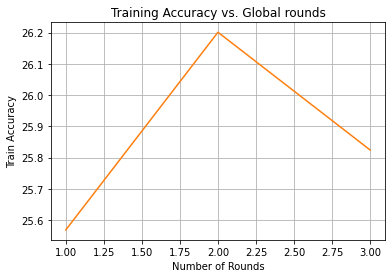

In [18]:
# number of training rounds
rounds = 3
# client fraction
C = 0.3
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 1
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
data_dict = iid_partition(training_set, 10)

loss_function = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()

distilbert_iid_trained = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [18]:
def calcuate_accuracy(big_idx, targets):
  n_correct = (big_idx==targets).sum().item()
  return n_correct

In [19]:
#Testing the trained model

def valid(model, testing_loader, loss_function):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            #token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask)
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [21]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(distilbert_iid_trained, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)

4it [00:00, 36.88it/s]

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 1.404465675354004
Validation Accuracy per 100 steps: 0.0


310it [00:05, 54.70it/s]

Validation Loss Epoch: 1.3719734822550127
Validation Accuracy Epoch: 27.62520193861066
Accuracy on test data = 27.63%


/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full b

Training Loss per 5000 steps: 1.383387565612793
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.42it/s]
2it [00:00, 15.02it/s]

The Total Accuracy for Epoch 1: 22.607993540573275
Training Loss Epoch: 1.3654128970638397
Training Accuracy Epoch: 22.607993540573275
Training Loss per 5000 steps: 1.3265650272369385
Training Accuracy per 5000 steps: 25.0


310it [00:22, 13.88it/s]
2it [00:00, 14.20it/s]

The Total Accuracy for Epoch 1: 22.28502220427937
Training Loss Epoch: 1.3643289054593732
Training Accuracy Epoch: 22.28502220427937
Training Loss per 5000 steps: 1.3813413381576538
Training Accuracy per 5000 steps: 12.5


310it [00:23, 13.33it/s]
2it [00:00, 14.51it/s]

The Total Accuracy for Epoch 1: 23.253936213161083
Training Loss Epoch: 1.364347150248866
Training Accuracy Epoch: 23.253936213161083
Round: 1... 	Average Loss: 1.365
Round: 1... 	Average Accuracy: 22.716
Training Loss per 5000 steps: 1.3716789484024048
Training Accuracy per 5000 steps: 37.5


310it [00:22, 13.96it/s]
2it [00:00, 14.66it/s]

The Total Accuracy for Epoch 1: 22.163907953169158
Training Loss Epoch: 1.3659463917055437
Training Accuracy Epoch: 22.163907953169158
Training Loss per 5000 steps: 1.3810703754425049
Training Accuracy per 5000 steps: 37.5


310it [00:22, 14.03it/s]
2it [00:00, 14.17it/s]

The Total Accuracy for Epoch 1: 22.68873637464675
Training Loss Epoch: 1.365975365331096
Training Accuracy Epoch: 22.68873637464675
Training Loss per 5000 steps: 1.3538907766342163
Training Accuracy per 5000 steps: 25.0


310it [00:22, 13.78it/s]
2it [00:00, 14.53it/s]

The Total Accuracy for Epoch 1: 22.5272507064998
Training Loss Epoch: 1.3646715214175562
Training Accuracy Epoch: 22.5272507064998
Round: 2... 	Average Loss: 1.366
Round: 2... 	Average Accuracy: 22.46
Training Loss per 5000 steps: 1.3371608257293701
Training Accuracy per 5000 steps: 25.0


310it [00:22, 13.76it/s]
2it [00:00, 14.21it/s]

The Total Accuracy for Epoch 1: 21.962050867985468
Training Loss Epoch: 1.3666792261985041
Training Accuracy Epoch: 21.962050867985468
Training Loss per 5000 steps: 1.3471897840499878
Training Accuracy per 5000 steps: 37.5


310it [00:22, 13.88it/s]
2it [00:00, 14.80it/s]

The Total Accuracy for Epoch 1: 22.446507872426324
Training Loss Epoch: 1.3657233107474542
Training Accuracy Epoch: 22.446507872426324
Training Loss per 5000 steps: 1.3529850244522095
Training Accuracy per 5000 steps: 37.5


310it [00:22, 13.92it/s]


The Total Accuracy for Epoch 1: 22.002422285022206
Training Loss Epoch: 1.365864554528267
Training Accuracy Epoch: 22.002422285022206
Round: 3... 	Average Loss: 1.366
Round: 3... 	Average Accuracy: 22.137
Training Done!
Total time taken to Train: 202.16471076011658


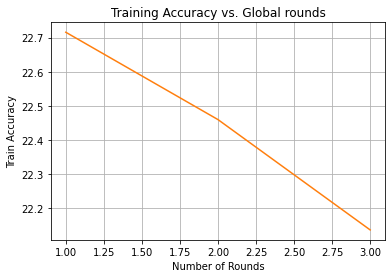

In [20]:
# number of training rounds
rounds = 3
# client fraction
C = 0.3
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 1
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
data_dict = non_iid_partition(training_set, 10, 240, 10, 10)
#iid_partition(training_set, 10)

loss_function = torch.nn.CrossEntropyLoss()
#model = 
if torch.cuda.is_available():
  model.cuda()

distilbert_non_iid_trained = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [ ]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(distilbert_non_iid_trained, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)

2it [00:00, 19.58it/s]

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 1.5456387996673584
Validation Accuracy per 100 steps: 100.0


310it [00:10, 29.83it/s]

Validation Loss Epoch: 1.5736979765276755
Validation Accuracy Epoch: 71.24394184168013
Accuracy on test data = 71.24%
